# Reading 3D MAS Datafiles 

This example illustrates reading the 3D temperature, density and emissivity files that went into the 4pi synthetic data example I sent earlier.

The 3D data is located here: https://www.predsci.com/~cdowns/files/psi_synth_4pi/3d_data/

*NOTE* The temperature and densities are natively on a staggered mesh. To make things easier, I interpolated them to the simple "main mesh" to match the 3D emissivity files (cell corners). They will be slightly smoother than the raw data, but I doubt it matters for this purpose.

Our HDF5 files can be read by the subroutines in our [psihdf](https://www.predsci.com/~cdowns/files/psi_synth_4pi/3d_data/psihdf.py) file. This requires the h5py package, which is a common package that should be easy to install with conda if your environment doesn't already have it.

In [1]:
import numpy as np
import scipy.interpolate
import psihdf
import torch
from torch import nn

import os, sys

# Add utils module to load stacks
_root_dir = os.path.abspath(os.getcwd()).split('/')[:-3]
_root_dir = os.path.join('/',*_root_dir)
sys.path.append(_root_dir)

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# from mayavi import mlab


from s4pi.maps.utilities.fibonacci_sphere import fibonacci_sphere
from s4pi.maps.evaluation.loader import SuNeRFLoader


ModuleNotFoundError: No module named 's4pi'

Define a simple class to facilitate reading the data files and holding the contents. It will also build an interpolator. Also define a function to print the shape, min, and max of an array.

In [ ]:
class Field3D:
    """
    Simple class to hold a 3D MAS field that is read in by a file.
    It has the field, the scales, and sets up the linear interpolator by default.
    """

    def __init__(self, hdf_file, get_interpolator=True):
        """
        initiate it by reading an hdf file.
        """
        # read the hdf file
        r, t, p, f = psihdf.rdhdf_3d(hdf_file)

        # transpose f so that the array is indexed as (r,t,p), like our fortran tools
        f = np.transpose(f)

        # save the tags
        self.r = r
        self.t = t
        self.p = p
        self.f = f

        # construct the linear interpolator
        if get_interpolator:
            interpolator = scipy.interpolate.RegularGridInterpolator((r, t, p), f)
            self.interpolator = interpolator
            
def shape_min_max(array, name):
    """
    Quick function to help illustrate array properties in a notebook
    """
    print(f'Info for {name}')
    print(f'  shape: {np.shape(array)}')
    print(f'  min: {np.min(array):10.4e}')
    print(f'  max: {np.max(array):10.4e}')
    print('')



Read the 3D temperature and density files. This is the electron temperature in MK.

In [ ]:
file_path = '/home/andres_munoz_j/psi_model/3d_data/'

te=Field3D(file_path+'mhd_ec19_super_01_all_te_3d_interp.h5')
ne = Field3D(file_path+'mhd_ec19_super_01_all_ne_3d_interp.h5')

# 3D Array
shape_min_max(te.f, "3D Te [MK]")

# 1D scales. These are the mesh point locations.
shape_min_max(te.r, "r: 1D radial locations, 1-30 [Rs]")
shape_min_max(te.t, "t: 1D co-latitude, 0-pi [radians]")
shape_min_max(te.p, "p: 1D Carrington longitude, 0-2pi [radians]")

Info for 3D Te [MK]
  shape: (445, 595, 1256)
  min: 1.6641e-02
  max: 4.3287e+00

Info for r: 1D radial locations, 1-30 [Rs]
  shape: (445,)
  min: 1.0000e+00
  max: 3.0000e+01

Info for t: 1D co-latitude, 0-pi [radians]
  shape: (595,)
  min: 0.0000e+00
  max: 3.1416e+00

Info for p: 1D Carrington longitude, 0-2pi [radians]
  shape: (1256,)
  min: 0.0000e+00
  max: 6.2832e+00



### Download and load nerf model

In [ ]:
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/psi/new_dens_temp/psi-full-stacks/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/psi/new_dens_temp/psi-full-stacks/save_state2-2-5k.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/psi/new_dens_temp/psi-full-stacks/save_state1-33-68k.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi-positional/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi-positional-32k/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/gaussian-scale-2/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/gaussian-scale2-lowr/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/ss_psi_poss_2_lowr/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/ss_psi_poss_0.5_lowr/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/ecl_pos_0.5_8vb/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi_poss_alta_0.5/save_state.snf'
# gc_chck_path = 'us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi_poss_alta_2/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi_poss_alta_20/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/psi_poss_alta_20_vol/save_state.snf'

# power density
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-17-power-density/ss-psi-poss-pow/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-17-power-density/ss_psi_poss_pow_512_2/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-17-power-density/ss_psi_poss_pow_512_skip_single/save_state.snf'


# single model
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_1/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_5/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_10/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_15/save_state.snf'


# single model no volumetric
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_5_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_6_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_7_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_8_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_9_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_10_nv/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/ss_psi_poss_pow_512_skip_single_15_nv/save_state.snf'


# single model no volumetric exp 9
gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_0/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_1/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_2/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_3/save_state.snf'
# gc_chck_path = 'gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_4/save_state.snf'



lcl_chck_path = '/home/andres_munoz_j/checkpoints/tmp/save_state2.snf'

gc_chck_path2 = 'gs://us-4pieuvirradiance-dev-models/09-03-gaussian_encoder/gaussian-scale-2/epoch=48-step=74000.ckpt'
lcl_chck_path2 = '/home/andres_munoz_j/checkpoints/tmp/save_state.ckpt'

os.makedirs('/'.join(lcl_chck_path.split('/')[:-1]), exist_ok=True)

!gsutil -m cp {gc_chck_path} {lcl_chck_path}
# !gsutil -m cp {gc_chck_path2} {lcl_chck_path2}

loader = SuNeRFLoader(lcl_chck_path)




Copying gs://us-4pieuvirradiance-dev-models/09-24-singlemodel/psi_single/ss_psi_poss_pow_512_skip_single_9_0/save_state.snf...
- [1/1 files][  7.4 MiB/  7.4 MiB] 100% Done                                    
Operation completed over 1 objects/7.4 MiB.                                      
{'d_input': 4, 'n_freqs': 10, 'scale_factor': 0.5, 'log_space': True}


### Define plotting points

In [ ]:
n_layers = 6
delta_r = .3

coordinates = []
for i in range(n_layers):
    coordinates.append(np.array(fibonacci_sphere(np.random.randint(1200, 4200)))*(1 + i*delta_r/(n_layers-1)))
coordinates = np.concatenate(coordinates)

x = coordinates[:,0]
y = coordinates[:,1]
z = coordinates[:,2]


r = np.sqrt(x**2 + y**2 + z**2)

x = x[r>1]
y = y[r>1]
z = z[r>1]

r = r[r>1]
theta = np.arccos(z/r)
phi = np.arctan2(y,x)
phi[phi<0] += 2*np.pi

# remove extrapolations
mask = np.logical_and(theta>np.min(te.t), theta<np.max(te.t))
r = r[mask]
theta = theta[mask]
phi = phi[mask]

x = x[mask]
y = y[mask]
z = z[mask]

# remove extrapolations
mask = np.logical_and(phi>np.min(te.p), phi<np.max(te.p))
r = r[mask]
theta = theta[mask]
phi = phi[mask]

x = x[mask]
y = y[mask]
z = z[mask]


coordinates_sp = np.concatenate((r[:,None], theta[:,None], phi[:,None]), axis=1)


### Interpolate PSI density and Temperature

In [ ]:
te_at_locs = np.log10(te.interpolator(coordinates_sp)*1e6)
ne_at_locs = np.log10(ne.interpolator(coordinates_sp))

### Run SuNeRF Inference

In [ ]:
time = 0
coordinates_ca = np.concatenate((-y[:,None], x[:,None], -z[:,None]), axis=1)
output_c, output_f = loader.run_inference(coordinates_ca, time)

# output_c[0][output_c[0]<=0] = 0
output_f[0][output_f[0]<=0] = 0

# base_rho  = 3.0
# base_temp = 5.5


base_rho = 10000.0
norm_rho = 171.0
pow_rho = 0.25
base_temp = 5.5

n_offset = 0.275

# density_c = torch.log10((nn.functional.relu(output_c[0][...,0])*norm_rho).pow(1/pow_rho) + base_rho) + n_offset
density_f = torch.log10((nn.functional.relu(output_f[0][...,0])*norm_rho).pow(1/pow_rho) + base_rho) + n_offset


MAE T 0.07449010928606917
MAE n 0.09737075140650353


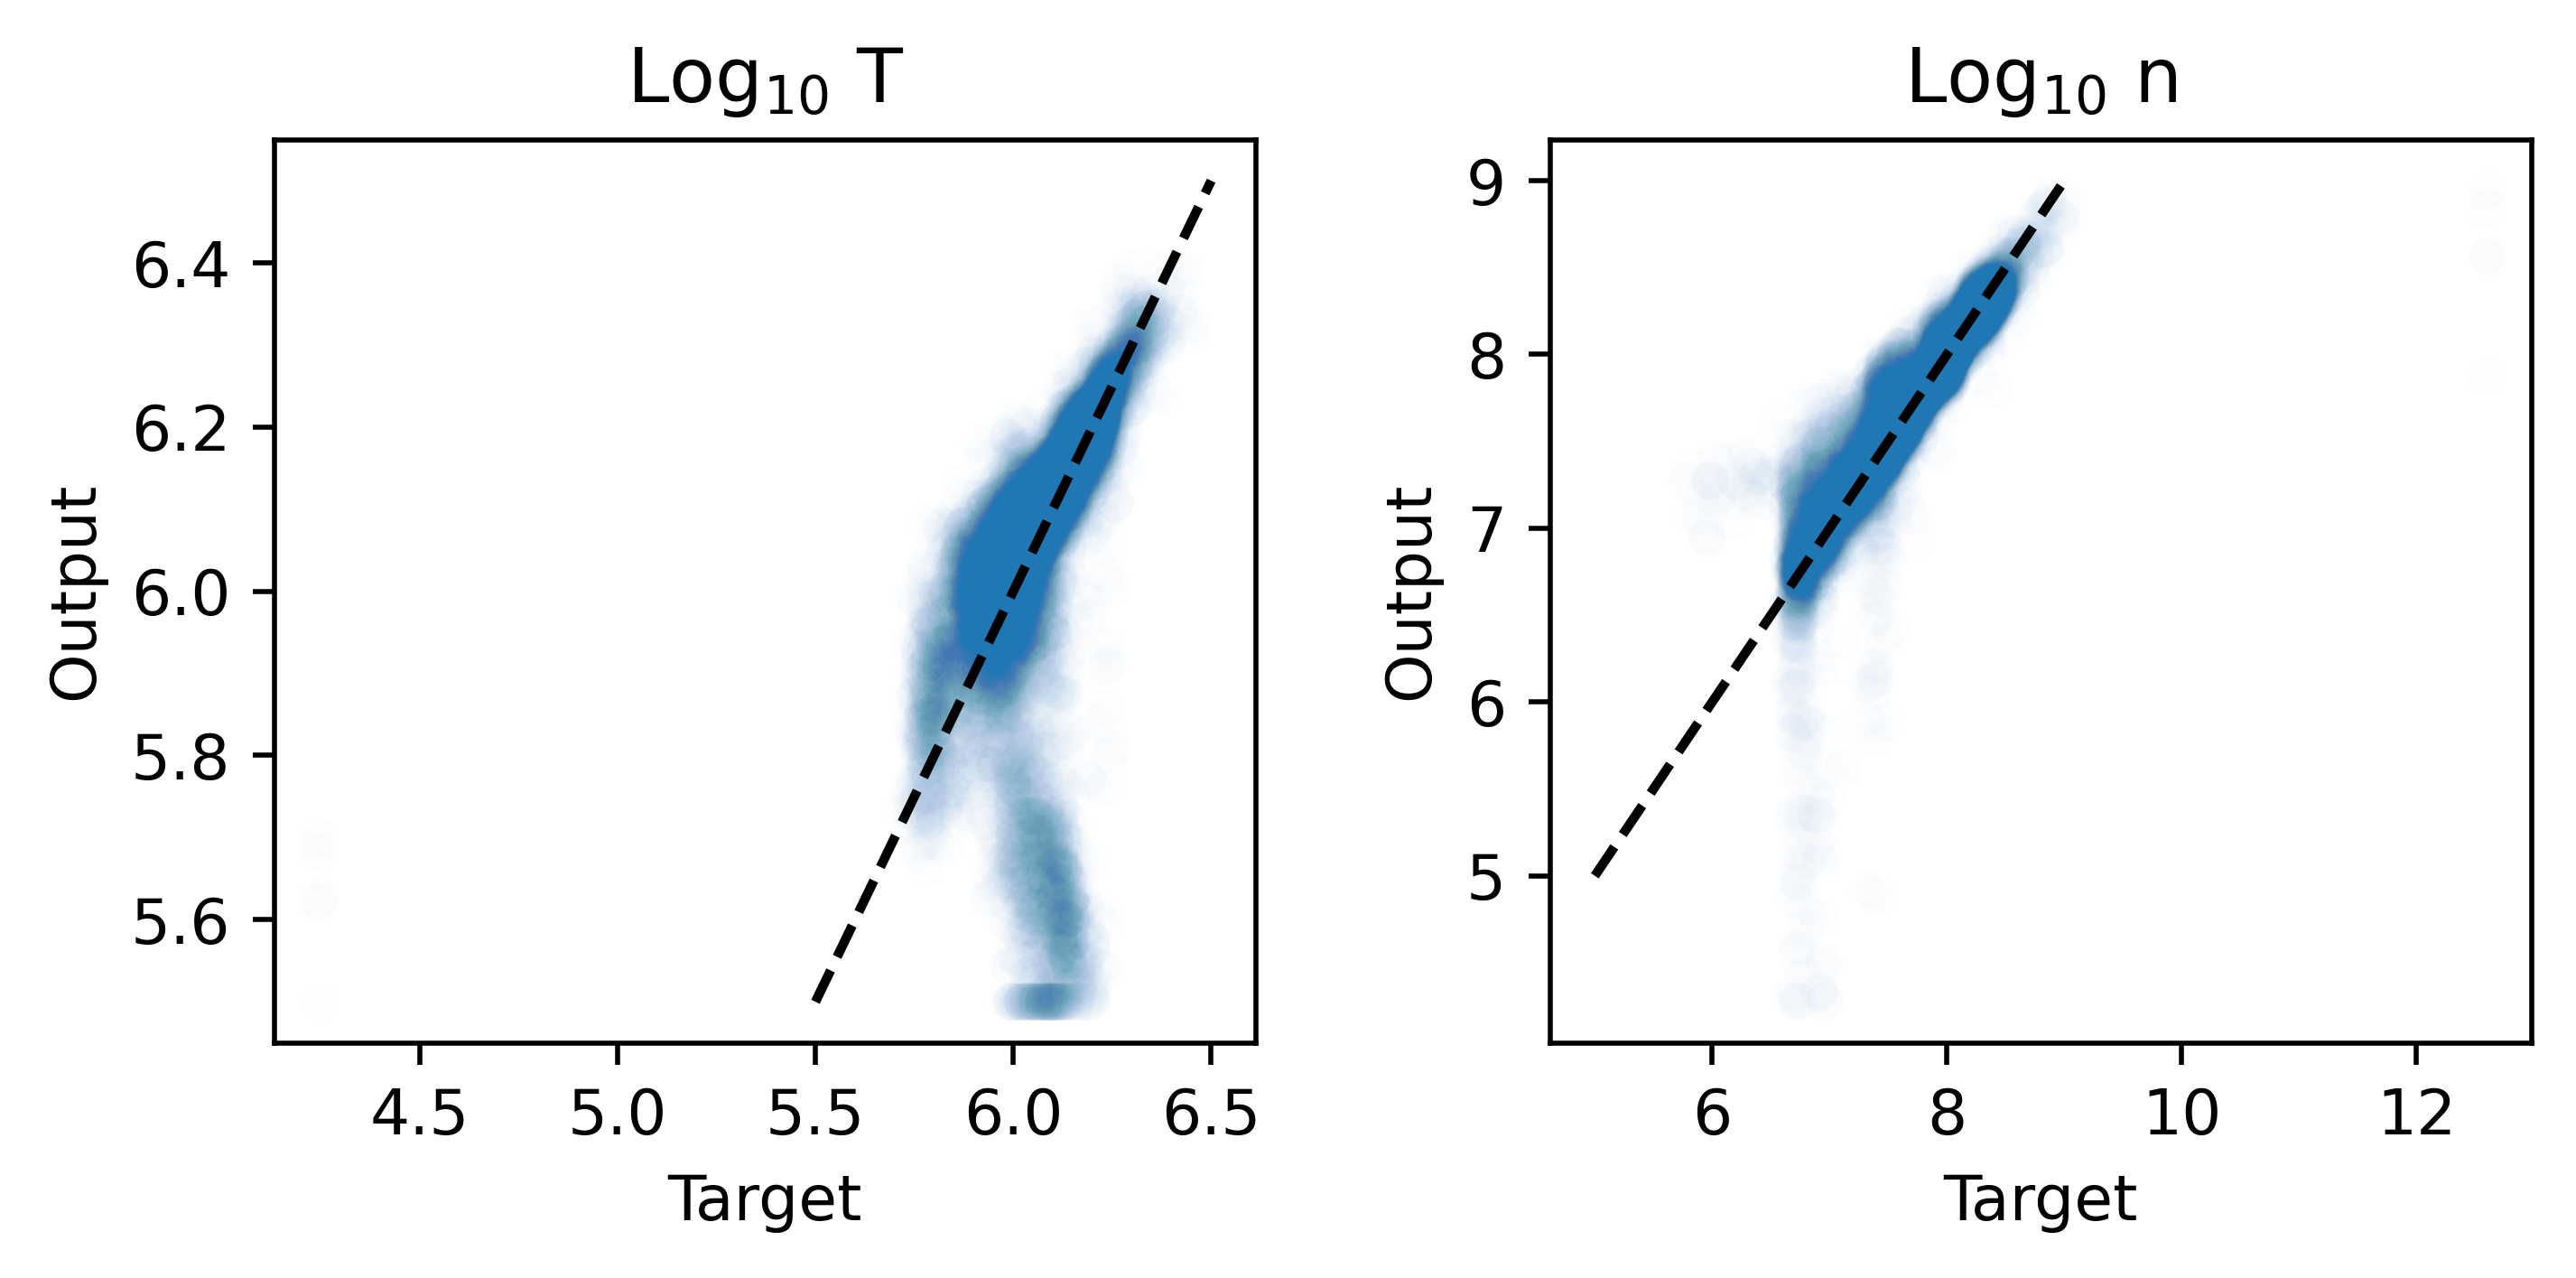

In [8]:
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

ax.scatter(te_at_locs,output_f[0][:,1].detach().cpu().numpy()+base_temp, alpha=0.01, ec='None')
ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_xlabel('Target')
ax.set_ylabel('Output')
ax.set_title('Log$_{10}$ T')

ax = fig.add_subplot(gs0[0, 1])
# ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
ax.scatter(ne_at_locs, density_f.detach().cpu().numpy(), alpha=0.01, ec='None')
ax.plot([5,9],[5,9], '--k')

ax.set_xlabel('Target')
ax.set_ylabel('Output')
ax.set_title('Log$_{10}$ n')

print('MAE T', np.nanmean(np.abs(output_f[0][:,1].detach().cpu().numpy()+base_temp-te_at_locs)))
print('MAE n', np.nanmean(np.abs(density_f.detach().cpu().numpy()-ne_at_locs)))

Text(0.5, 1.0, 'Log$_{10}$ n')

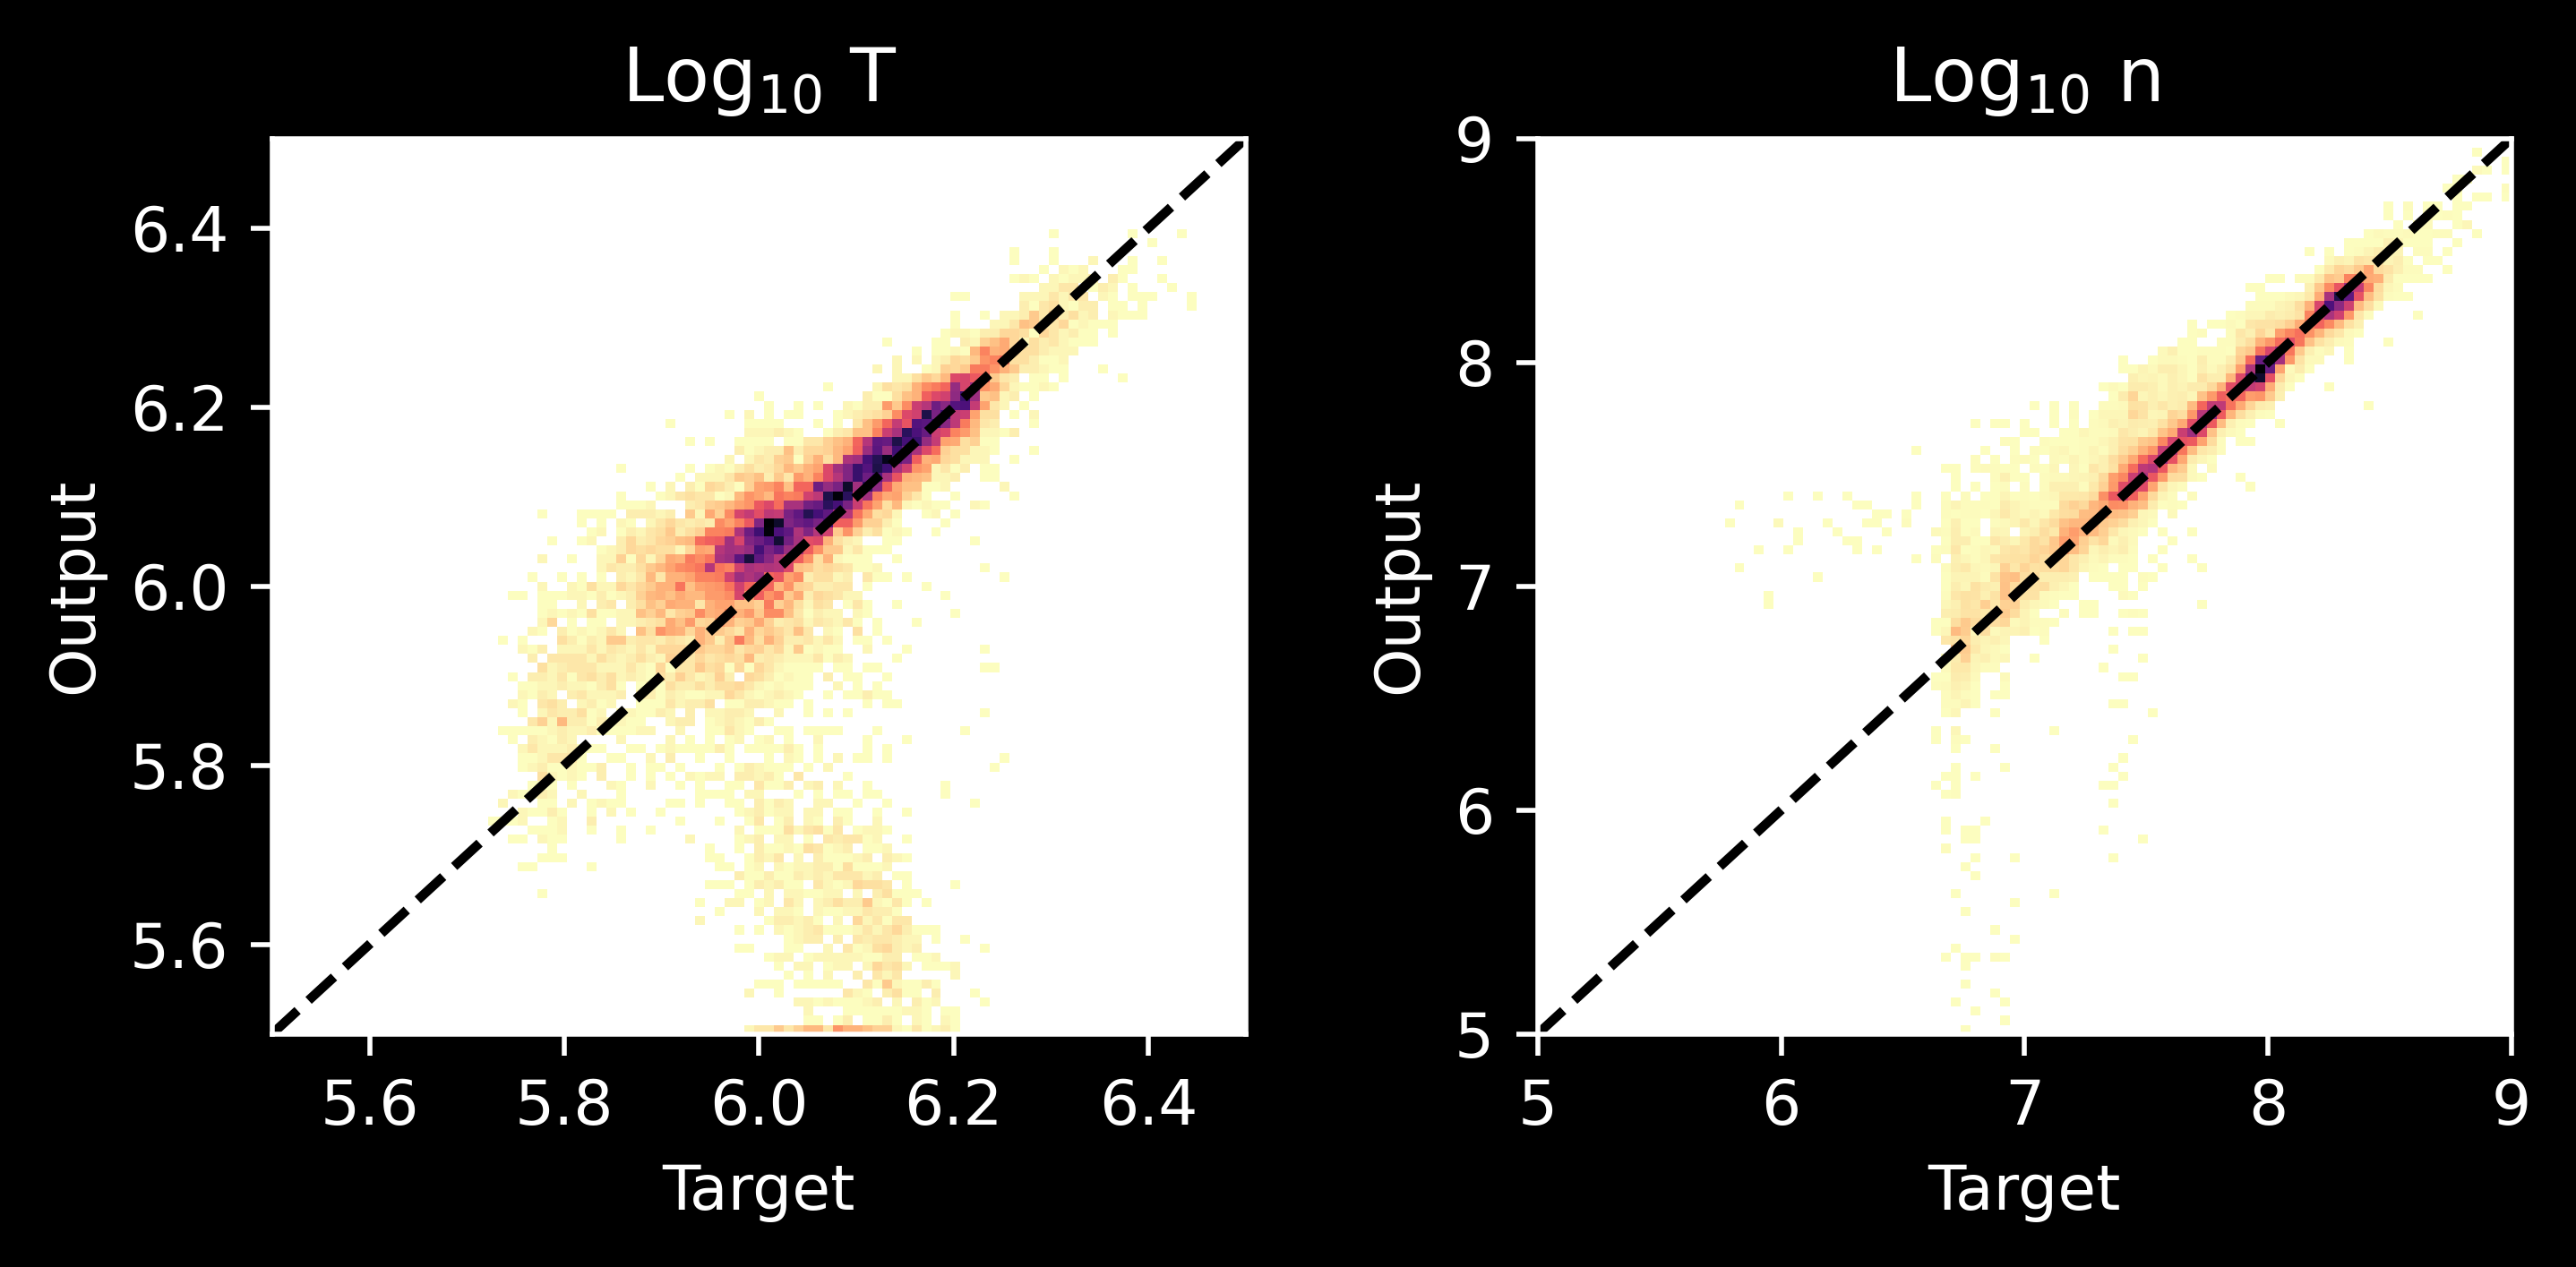

In [19]:
fig = plt.figure(figsize=2*np.array([2.5, 1]), dpi=500)
gs0 = fig.add_gridspec(1, 2, wspace=0.3, hspace=0, left=0, right=1, bottom=0, top=1)

ax = fig.add_subplot(gs0[0, 0])

x1 = 5.5
x2 = 6.5
nbins = 100

xbins = np.linspace(x1, x2, nbins)

cmap = mpl.cm.get_cmap('magma_r').copy()
cmap.set_under('w',1)

ax.hist2d(te_at_locs,output_f[0][:,1].detach().cpu().numpy()+base_temp, bins=xbins, cmap=cmap, cmin=1)
ax.plot([5.5,6.5],[5.5,6.5], '--k')
ax.set_facecolor('w')
ax.set_xlabel('Target')
ax.set_ylabel('Output')
ax.set_title('Log$_{10}$ T')

x1 = 5
x2 = 9
nbins = 100

xbins = np.linspace(x1, x2, nbins)

ax = fig.add_subplot(gs0[0, 1])
# ax.scatter(ne_at_locs,output_f[0][:,0].detach().cpu().numpy()+base_rho, alpha=0.01, ec='None')
ax.hist2d(ne_at_locs, density_f.detach().cpu().numpy(), bins=xbins, cmap=cmap, cmin=1)
ax.plot([5,9],[5,9], '--k')
ax.set_facecolor('w')

ax.set_xlabel('Target')
ax.set_ylabel('Output')
ax.set_title('Log$_{10}$ n')

In [10]:
for wl, coef in output_f[1].items():
    print(coef, wl)

Parameter containing:
tensor(4.4000, device='cuda:0', requires_grad=True) 94
Parameter containing:
tensor(4.2000, device='cuda:0', requires_grad=True) 131
Parameter containing:
tensor(2.7640, device='cuda:0', requires_grad=True) 171
Parameter containing:
tensor(3.3293, device='cuda:0', requires_grad=True) 193
Parameter containing:
tensor(3.9539, device='cuda:0', requires_grad=True) 211
Parameter containing:
tensor(3.4000, device='cuda:0', requires_grad=True) 304
Parameter containing:
tensor(3.2000, device='cuda:0', requires_grad=True) 335


In [11]:
output_f[2]

1.0

In [12]:
for name, param in loader.fine_model.named_parameters():
    if param.requires_grad and 'output' not in name and 'layers' not in name:
        print(name, param)


rho_0 Parameter containing:
tensor(0.6957, device='cuda:0', requires_grad=True)
h0 Parameter containing:
tensor(0.1079, device='cuda:0', requires_grad=True)
t0 Parameter containing:
tensor(6.0331, device='cuda:0', requires_grad=True)
log_absortpion.94 Parameter containing:
tensor(4.4000, device='cuda:0', requires_grad=True)
log_absortpion.131 Parameter containing:
tensor(4.2000, device='cuda:0', requires_grad=True)
log_absortpion.171 Parameter containing:
tensor(2.7640, device='cuda:0', requires_grad=True)
log_absortpion.193 Parameter containing:
tensor(3.3293, device='cuda:0', requires_grad=True)
log_absortpion.211 Parameter containing:
tensor(3.9539, device='cuda:0', requires_grad=True)
log_absortpion.304 Parameter containing:
tensor(3.4000, device='cuda:0', requires_grad=True)
log_absortpion.335 Parameter containing:
tensor(3.2000, device='cuda:0', requires_grad=True)


## Plot densities

In [13]:
# N=200
# stride=1

# u = np.linspace(0, 2 * np.pi, N)
# v = np.linspace(0, np.pi, N)
# x_sp = np.outer(np.cos(u), np.sin(v))
# y_sp = np.outer(np.sin(u), np.sin(v))
# z_sp = np.outer(np.ones(np.size(u)), np.cos(v))


# vmin = 5.5
# vmax = 6.4
# cmap = mpl.cm.get_cmap('cividis')
# norm = mpl.colors.Normalize(vmin=5.5, vmax=6.4)

# fig = plt.figure(figsize=2*np.array([3, 4]), dpi=500)
# gs0 = fig.add_gridspec(4, 3, wspace=0.1, hspace=0, left=0, right=1, bottom=0, top=1)

# te_c = output_c[0][:,1].detach().cpu().numpy()+base_temp
# alpha = (te_c - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(te_c))
# colors[:,3] = alpha

# ax = fig.add_subplot(gs0[0, 0], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.set_title('Coarse Model')



# te_f = output_f[0][:,1].detach().cpu().numpy()+base_temp
# alpha = (te_f - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(te_f))
# colors[:,3] = alpha


# ax = fig.add_subplot(gs0[0, 1], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.set_title('Fine Model')



# alpha = (te_at_locs - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(te_at_locs))
# colors[:,3] = alpha


# ax = fig.add_subplot(gs0[0, 2], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.set_title('PSI')

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.03,ax.get_position().height])
# plt.colorbar(sm, cax=cax)
# cax.set_ylabel('Log$_{10}$ T')


# # temperature difference
# # ---------------------------------------------------------------------------------------
# vmind = -0.2
# vmaxd = .2
# dcmap = mpl.cm.get_cmap('RdYlGn')
# norm = mpl.colors.Normalize(vmin=vmind, vmax=vmaxd)

# te_c = output_c[0][:,1].detach().cpu().numpy()+base_temp
# alpha = (te_c - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = dcmap(norm(te_c-te_at_locs))
# colors[:,3] = alpha

# ax = fig.add_subplot(gs0[1, 0], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.set_title('Coarse Model')



# te_f = output_f[0][:,1].detach().cpu().numpy()+base_temp
# alpha = (te_f - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = dcmap(norm(te_f-te_at_locs))
# colors[:,3] = alpha

# ax = fig.add_subplot(gs0[1, 1], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# ax.set_title('Fine Model')


# sm = plt.cm.ScalarMappable(cmap=dcmap, norm=norm)
# sm.set_array([])
# cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.03,ax.get_position().height])
# plt.colorbar(sm, cax=cax)
# cax.set_ylabel('Log$_{10}$ T')

# # Density
# # ---------------------------------------------------------------------------------------------


# alpha = ne_at_locs
# alpha = alpha - np.min(alpha)
# alpha = alpha/np.max(alpha)#*.75 + .25


# vmin = 6
# vmax = 9
# cmap = mpl.cm.get_cmap('magma_r')
# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# colors = cmap(norm(ne_at_locs))
# colors[:,3] = alpha


# ne_c = density_c.detach().cpu().numpy()
# alpha = (ne_c - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(ne_c))
# colors[:,3] = alpha

# ax = fig.add_subplot(gs0[2, 0], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# # ax.set_title('Coarse Model')



# ne_f = density_f.detach().cpu().numpy()
# alpha = (ne_f - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(ne_f))
# colors[:,3] = alpha


# ax = fig.add_subplot(gs0[2, 1], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# # ax.set_title('Fine Model')



# alpha = (ne_at_locs - vmin)/(vmax-vmin)
# alpha[alpha<0] = 0
# alpha[alpha>1] = 1
# colors = cmap(norm(ne_at_locs))
# colors[:,3] = alpha


# ax = fig.add_subplot(gs0[2, 2], projection='3d')
# ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
# sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

# ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_zticklabels([])
# # ax.set_title('PSI')

# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.03,ax.get_position().height])
# plt.colorbar(sm, cax=cax)
# cax.set_ylabel('Log$_{10}$ n')



Text(0, 0.5, 'Log$_{10}$ T$_{ML}$ - Log$_{10}$ T$_{PSI}$')

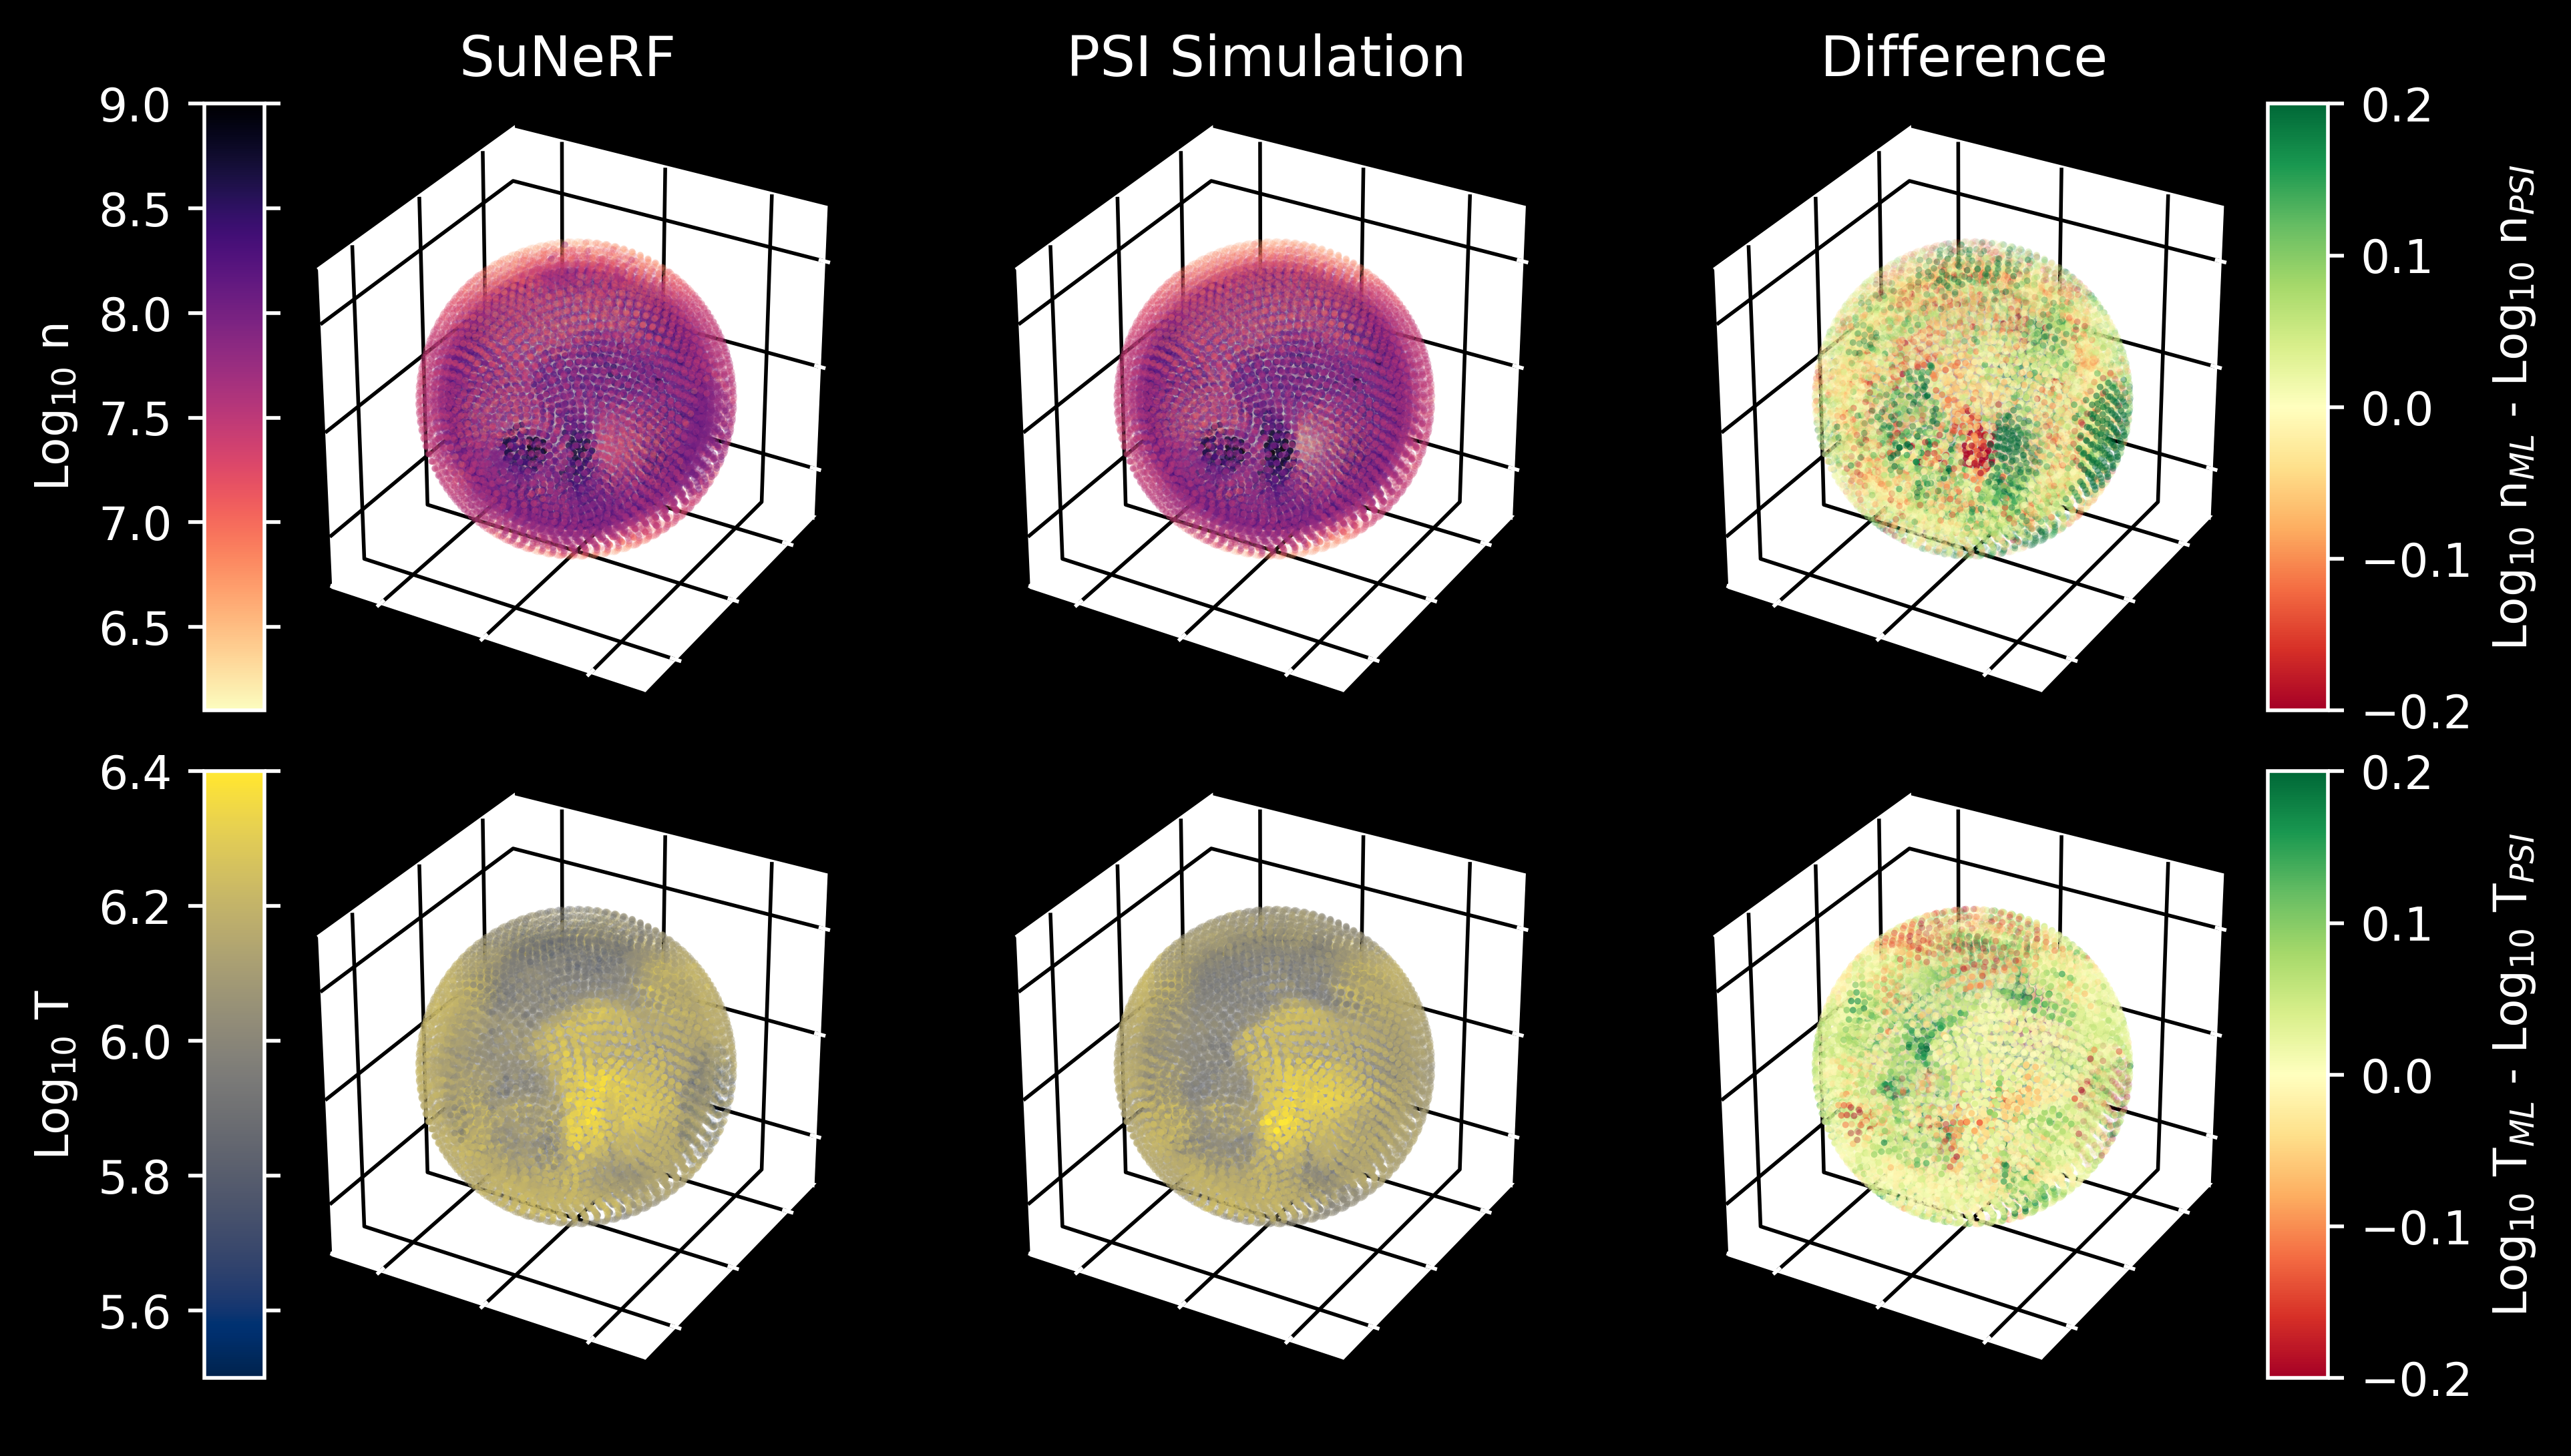

In [14]:
plt.style.use('dark_background')
plt.rcParams['grid.color'] = "k"

N=200
stride=1

u = np.linspace(0, 2 * np.pi, N)
v = np.linspace(0, np.pi, N)
x_sp = np.outer(np.cos(u), np.sin(v))
y_sp = np.outer(np.sin(u), np.sin(v))
z_sp = np.outer(np.ones(np.size(u)), np.cos(v))



fig = plt.figure(figsize=2*np.array([3, 2]), dpi=500)
gs0 = fig.add_gridspec(2, 3, wspace=0.15, hspace=0, left=0, right=1, bottom=0, top=1)



# Density
# ---------------------------------------------------------------------------------------------
vmin = 6
vmax = 9
ne_f = density_f.detach().cpu().numpy()
alpha = (ne_f - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1

vmin = 6.1
vmax = 9
cmap = mpl.cm.get_cmap('magma_r')
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
colors = cmap(norm(ne_at_locs))
colors[:,3] = alpha



colors = cmap(norm(ne_f))
colors[:,3] = alpha


ax = fig.add_subplot(gs0[0, 0], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('SuNeRF')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cax = fig.add_axes([ax.get_position().x0-0.03,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(sm, cax=cax)
cax.set_ylabel('Log$_{10}$ n')
cax.yaxis.tick_left()
cax.yaxis.set_ticks_position('both')
cax.yaxis.set_label_position('left')



alpha = (ne_at_locs - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1
colors = cmap(norm(ne_at_locs))
colors[:,3] = alpha


ax = fig.add_subplot(gs0[0, 1], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('PSI Simulation')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))



# Density difference
# ---------------------------------------------------------------------------------------
vmind = -0.2
vmaxd = .2
dcmap = mpl.cm.get_cmap('RdYlGn')
norm = mpl.colors.Normalize(vmin=vmind, vmax=vmaxd)


ne_f = density_f.detach().cpu().numpy()
alpha = (ne_f - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1
colors = dcmap(norm(ne_f-ne_at_locs))
colors[:,3] = alpha

ax = fig.add_subplot(gs0[0, 2], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('Difference')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


sm = plt.cm.ScalarMappable(cmap=dcmap, norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(sm, cax=cax)
cax.set_ylabel('Log$_{10}$ n$_{ML}$ - Log$_{10}$ n$_{PSI}$')



# Temperature
# ---------------------------------------------------------------------------------------------


vmin = 5.5
vmax = 6.4
cmap = mpl.cm.get_cmap('cividis')
norm = mpl.colors.Normalize(vmin=5.5, vmax=6.4)


te_f = output_f[0][:,1].detach().cpu().numpy()+base_temp
alpha = (te_f - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1
colors = cmap(norm(te_f))
colors[:,3] = alpha


ax = fig.add_subplot(gs0[1, 0], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_title('SuNeRF')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cax = fig.add_axes([ax.get_position().x0-0.03,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(sm, cax=cax)
cax.set_ylabel('Log$_{10}$ T')
cax.yaxis.tick_left()
cax.yaxis.set_ticks_position('both')
cax.yaxis.set_label_position('left')


alpha = (te_at_locs - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1
colors = cmap(norm(te_at_locs))
colors[:,3] = alpha


ax = fig.add_subplot(gs0[1, 1], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_title('PSI Simulation')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


# temperature difference
# ---------------------------------------------------------------------------------------
vmind = -0.2
vmaxd = .2
dcmap = mpl.cm.get_cmap('RdYlGn')
norm = mpl.colors.Normalize(vmin=vmind, vmax=vmaxd)


te_f = output_f[0][:,1].detach().cpu().numpy()+base_temp
alpha = (te_f - vmin)/(vmax-vmin)
alpha[alpha<0] = 0
alpha[alpha>1] = 1
colors = dcmap(norm(te_f-te_at_locs))
colors[:,3] = alpha

ax = fig.add_subplot(gs0[1, 2], projection='3d')
ax.plot_surface(y_sp, z_sp, x_sp, linewidth=0.0, cstride=stride, rstride=stride, color='0.75', shade=False, alpha=1)
sc = ax.scatter(x,y,z, c = colors, lw=0, s=2)

ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
# ax.set_title('Difference')

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))


sm = plt.cm.ScalarMappable(cmap=dcmap, norm=norm)
sm.set_array([])
cax = fig.add_axes([ax.get_position().x1,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(sm, cax=cax)
cax.set_ylabel('Log$_{10}$ T$_{ML}$ - Log$_{10}$ T$_{PSI}$')

In [15]:
ax.get_position().x0

0.696969696969697

In [16]:
te_c = output_c[0][:,1].detach().cpu().numpy()+base_temp

TypeError: 'NoneType' object is not subscriptable

In [ ]:
np.max(ne_c-ne_at_locs)

1.0415795337991893

In [ ]:
np.min(ne_c-ne_at_locs)

-5.3769992582745925

In [ ]:
np.mean(np.abs(ne_c-ne_at_locs))

0.28772646845573174

In [ ]:
np.std(np.abs(ne_c-ne_at_locs))

0.1517133199667845

In [ ]:
output_f[2]

Parameter containing:
tensor(0.9323, device='cuda:0', requires_grad=True)

In [ ]:
np.log10(23)

1.3617278360175928

In [ ]:
np.log10(1.4e6)

6.146128035678238

In [ ]:
np.log10(5777)

3.7617023675414125

In [ ]:
np.log10(3.0e8)

8.477121254719663